# Stellar Metallicity

In [24]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.paths import Paths
from auriga.parser import parse
from auriga.settings import Settings

In [10]:
figure_setup()

## [Mg/Fe] vs [Fe/H]

In [48]:
def read_data(simulation: str) -> tuple:
    """
    This method returns data of interest for this analysis.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The properties.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)
    s.add_metal_abundance(of="Fe", to="H")
    s.add_metal_abundance(of="Mg", to="Fe")

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    return (s.metal_abundance["Fe/H"][is_real_star & is_main_obj],
            s.metal_abundance["Mg/Fe"][is_real_star & is_main_obj],
            s.region_tag[is_real_star & is_main_obj],
            s.v_phi[is_real_star & is_main_obj])

In [49]:
def plot_abundance_rel_for_galaxy(simulation: str):
    """
    This method creates a plot of the Mg/Fe abundance as a function of the
    Fe\H abundance for all subhalo stars.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(3.0, 3.0))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    ax.label_outer()
    ax.tick_params(which='both', direction="in")
    ax.set_xlim(-2, 1)
    ax.set_ylim(-0.1, 0.4)
    ax.set_xticks([-2, -1, 0, 1])
    ax.set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
    ax.set_xlabel("[Fe/H] [dex]")
    ax.set_ylabel("$\mathrm{[Mg/Fe]} + 0.4$ [dex]")

    fe_to_h, mg_to_fe, _, _ = read_data(simulation=simulation)
    _, _, _, im = ax.hist2d(fe_to_h,
                            mg_to_fe + 0.4,
                            cmap="nipy_spectral",
                            bins=200,
                            range=[ax.get_xlim(), ax.get_ylim()],
                            norm=mcolors.LogNorm(vmin=1E0, vmax=1E3))
    ax.plot(ax.get_xlim(),
            [np.nanmedian(mg_to_fe + 0.4),
             np.nanmedian(mg_to_fe + 0.4)],
            lw=.25, color='k')
    ax.plot([np.nanmedian(fe_to_h),
             np.nanmedian(fe_to_h)],
            ax.get_ylim(),
            lw=.25, color='k')
    ax.plot(np.nanmedian(fe_to_h),
            np.nanmedian(mg_to_fe + 0.4),
            marker='o', mfc='k', ms=2, mew=0)

    cbar = fig.colorbar(im, ax=ax, orientation='vertical',
                        label=r'$N_\mathrm{stars}$',
                        pad=0)
    cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

    ax.text(x=ax.get_xlim()[0],
            y=ax.get_ylim()[1],
            s=r"$\texttt{" + simulation.upper() + "}$",
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

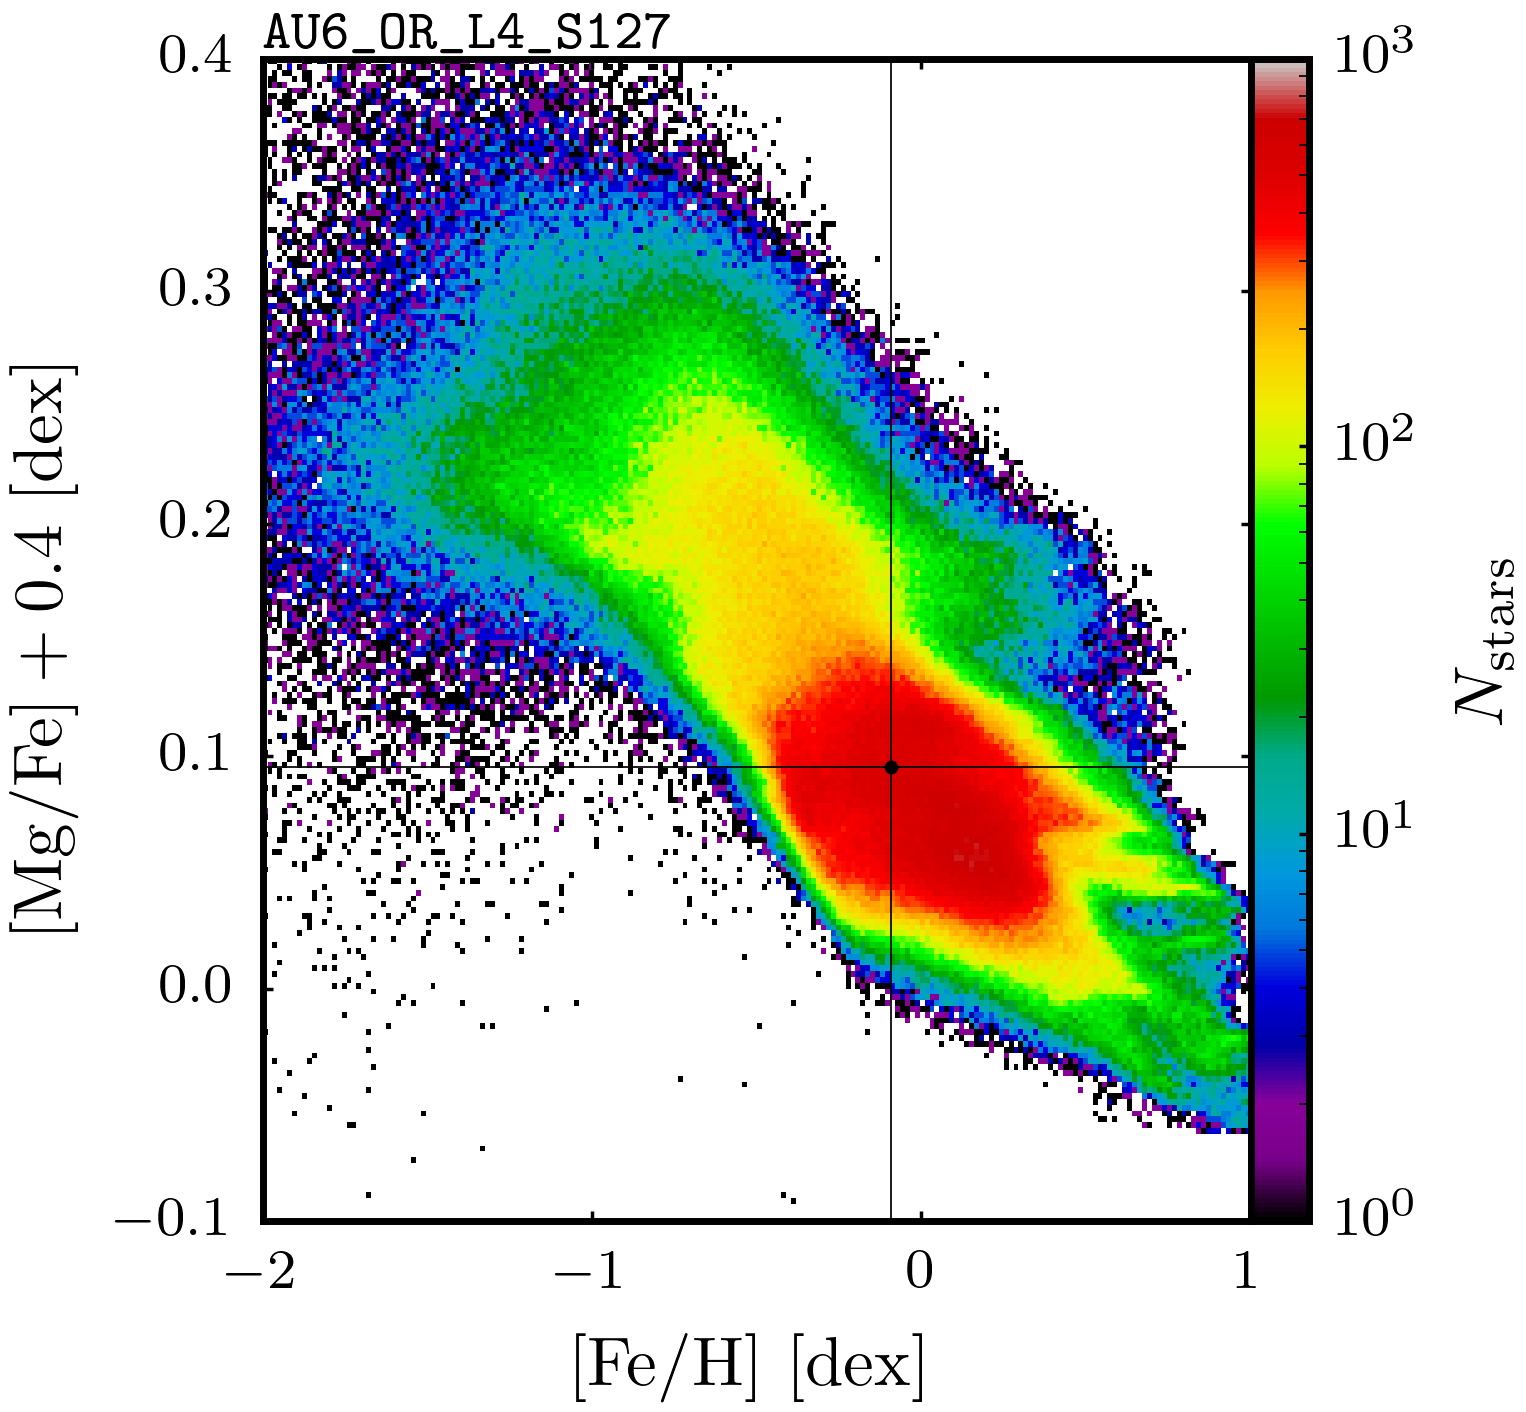

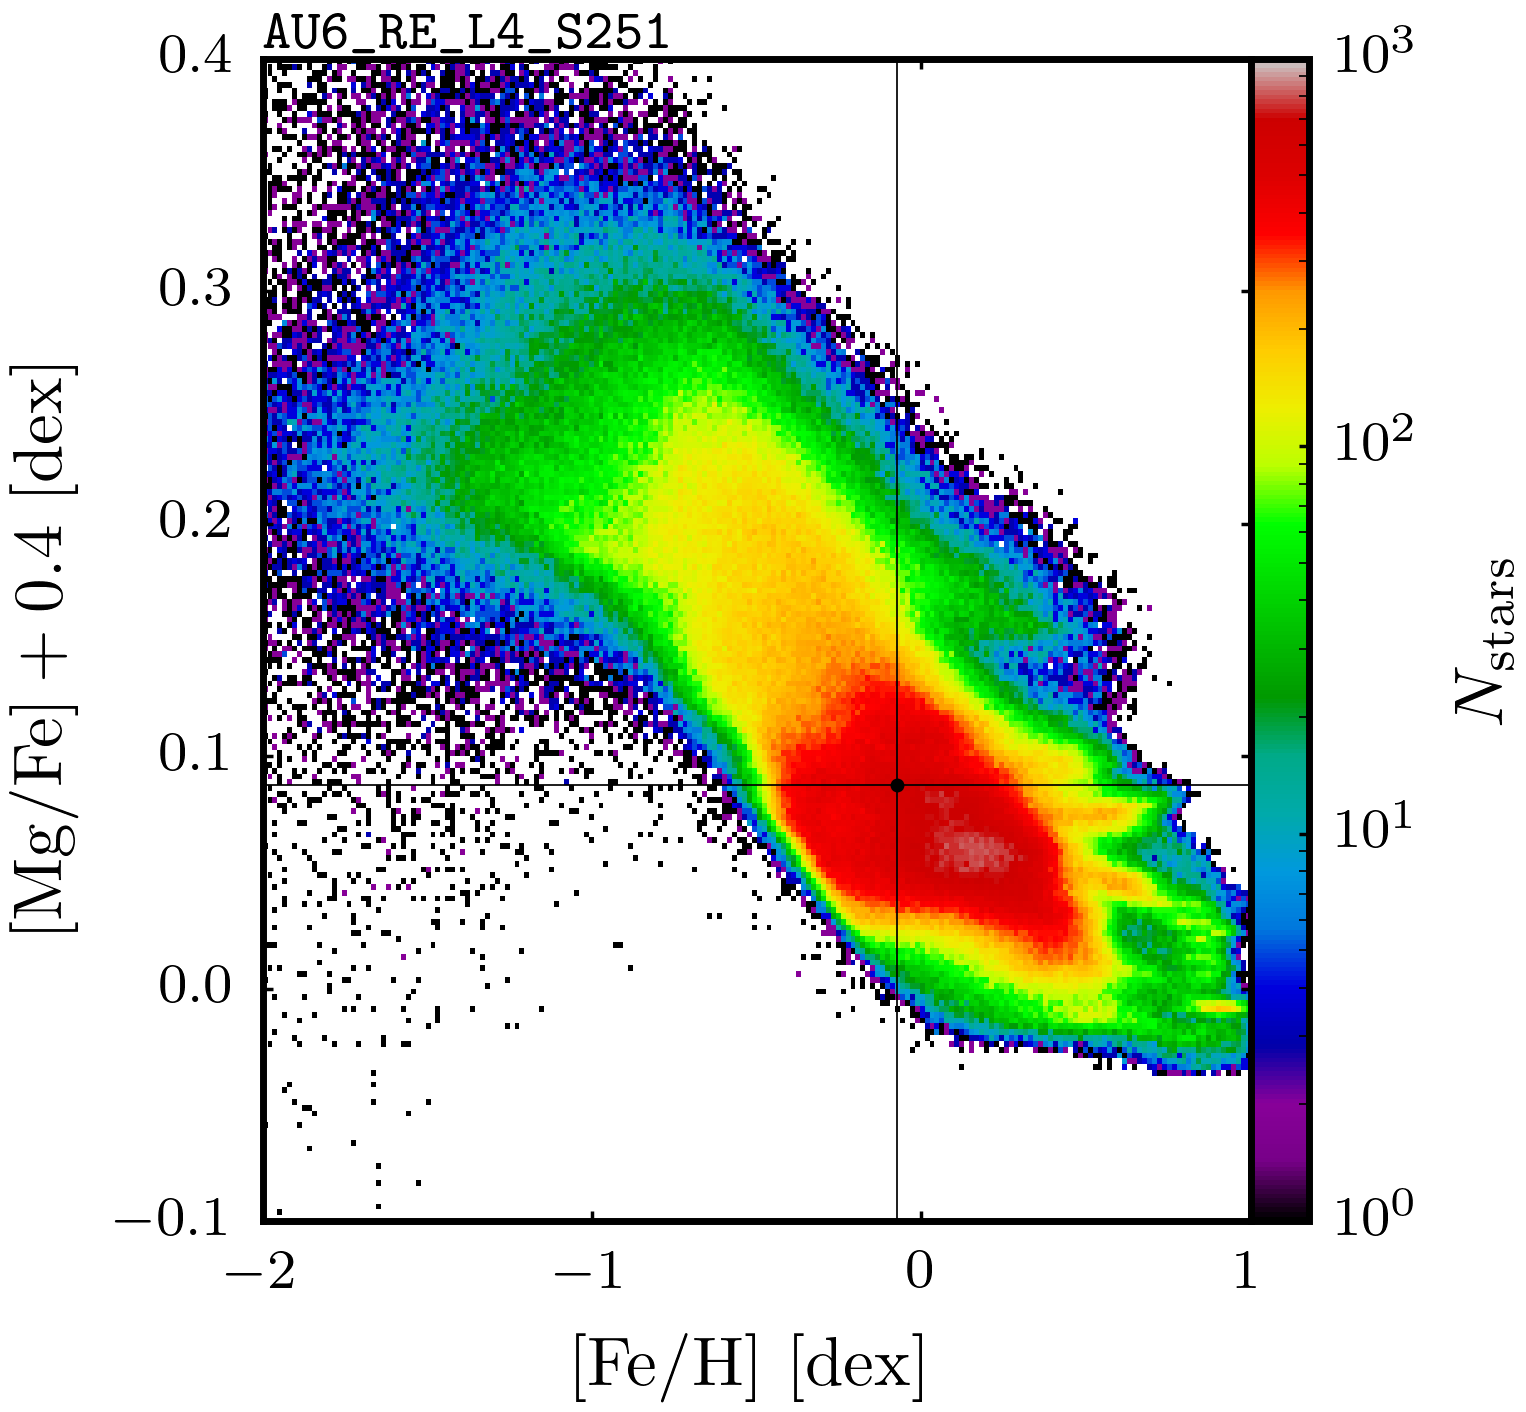

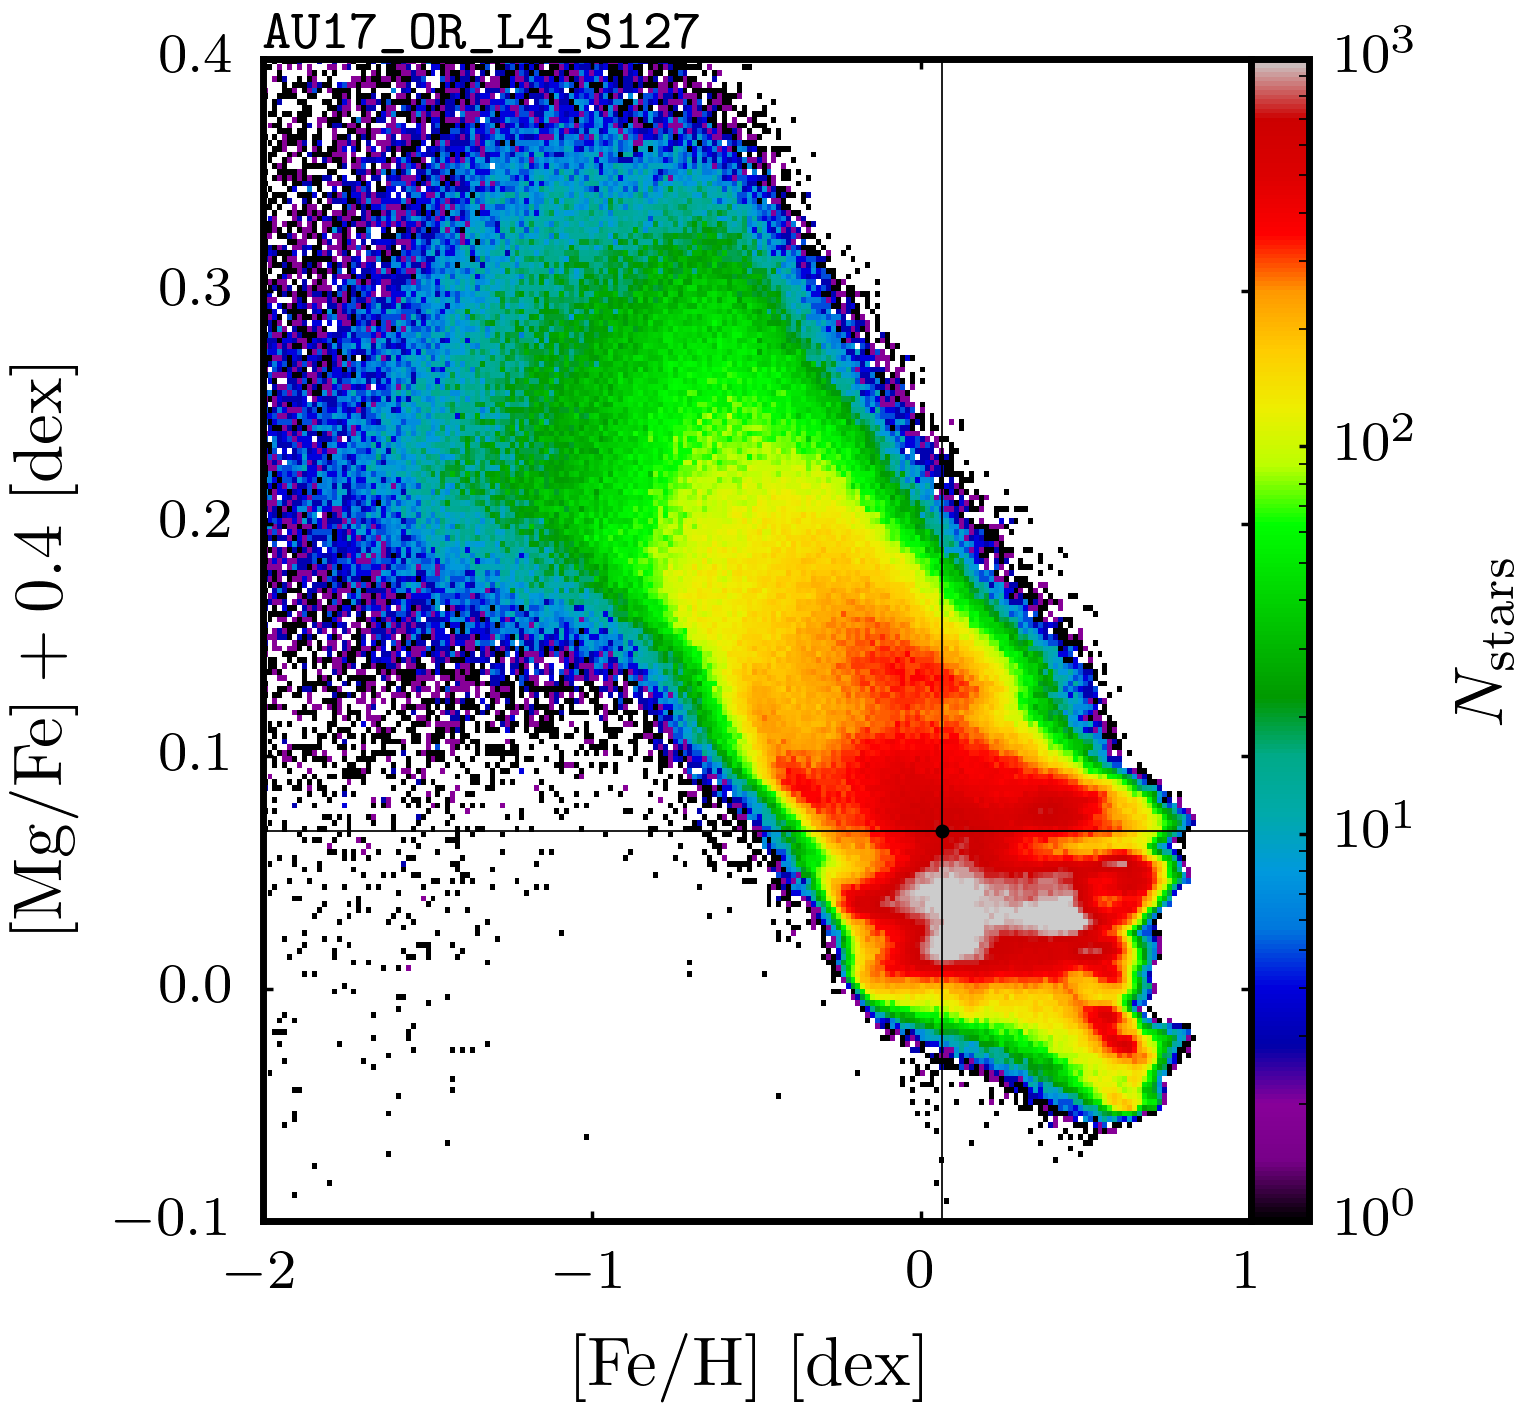

In [50]:
plot_abundance_rel_for_galaxy(simulation="au6_or_l4_s127")
plot_abundance_rel_for_galaxy(simulation="au6_re_l4_s251")
plot_abundance_rel_for_galaxy(simulation="au17_or_l4_s127")
plot_abundance_rel_for_galaxy(simulation="au18_or_l4_s127")

In [51]:
def plot_abundance_rel_by_region_for_galaxy(simulation: str):
    """
    This method creates a plot of the Mg/Fe abundance as a function of the
    Fe\H abundance for each galactic component.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """
    settings = Settings()

    fig = plt.figure(figsize=(7.4, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    for ax in axs.flat:
        ax.tick_params(which='both', direction="in")
        ax.set_xlim(-2, 1)
        ax.set_ylim(-0.1, 0.4)
        ax.set_xticks([-1, 0, 1])
        ax.set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
        ax.set_xlabel("[Fe/H] [dex]")
        ax.set_ylabel("$\mathrm{[Mg/Fe]} + 0.4$ [dex]")
        ax.label_outer()

    fe_to_h, mg_to_fe, region_tag, _ = read_data(simulation=simulation)
    for idx, tag in enumerate(np.unique(region_tag)):
        is_region = (region_tag == tag)
        _, _, _, im = axs[idx].hist2d(
            fe_to_h[is_region],
            mg_to_fe[is_region] + 0.4,
            cmap='nipy_spectral',
            bins=200,
            range=[axs[idx].get_xlim(), axs[idx].get_ylim()],
            norm=mcolors.LogNorm(vmin=1E0, vmax=1E3))

        axs[idx].text(x=0.05,
                      y=0.05,
                      s=settings.component_labels[settings.components[idx]],
                      size=8.0, transform=axs[idx].transAxes,
                      ha='left', va='bottom',
                      )

        axs[idx].plot(axs[idx].get_xlim(),
                      [np.nanmedian(mg_to_fe[is_region] + 0.4),
                       np.nanmedian(mg_to_fe[is_region] + 0.4)],
                      lw=.25, color='k')
        axs[idx].plot([np.nanmedian(fe_to_h[is_region]),
                       np.nanmedian(fe_to_h[is_region])],
                      axs[idx].get_ylim(),
                      lw=.25, color='k')
        axs[idx].plot(np.nanmedian(fe_to_h[is_region]),
                      np.nanmedian(mg_to_fe[is_region] + 0.4),
                     marker='o', mfc='k', ms=2, mew=0)

    cbar = fig.colorbar(im, ax=axs[-1], orientation='vertical',
                        label=r'$N_\mathrm{stars}$',
                        pad=0)
    cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

    axs[0].text(x=axs[0].get_xlim()[0],
                y=axs[0].get_ylim()[1],
                s=r"$\texttt{" + simulation.upper() + "}$",
                size=8.0,
                ha='left', va='bottom',
                )

    plt.show()

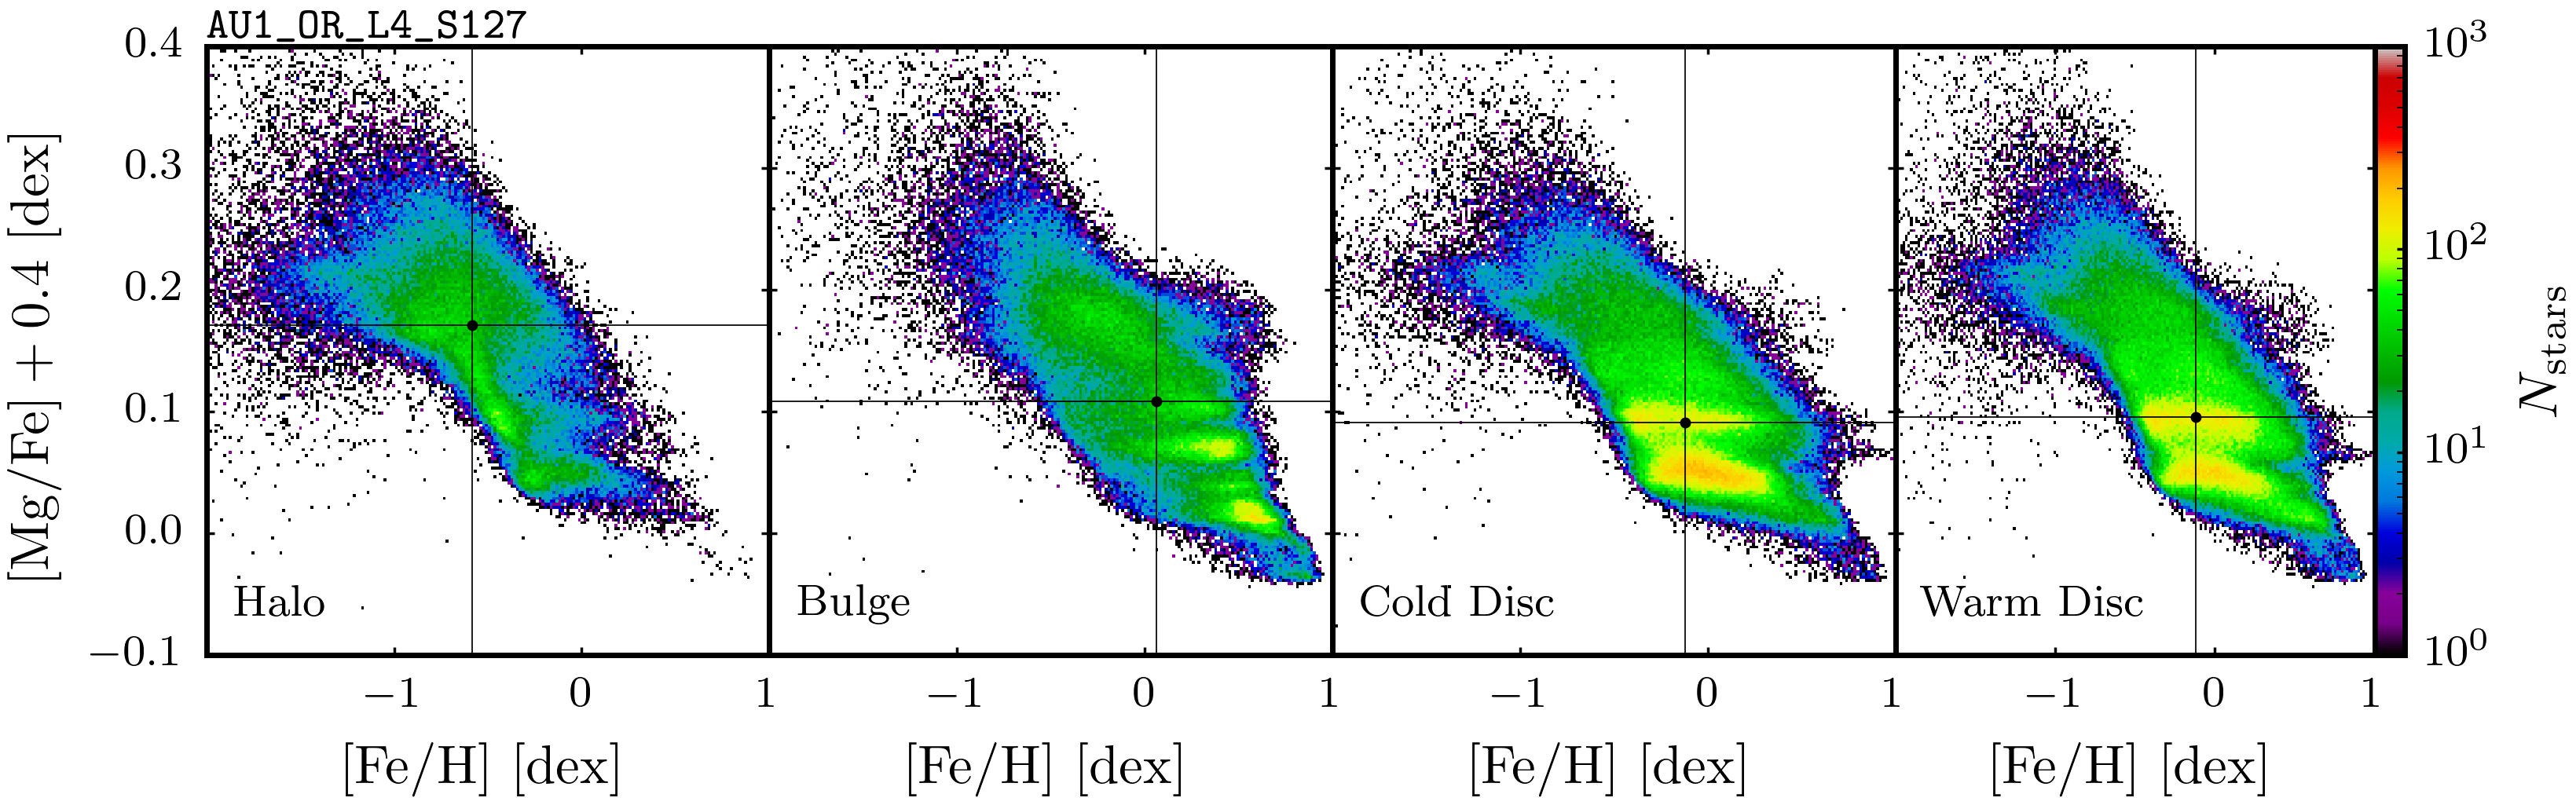

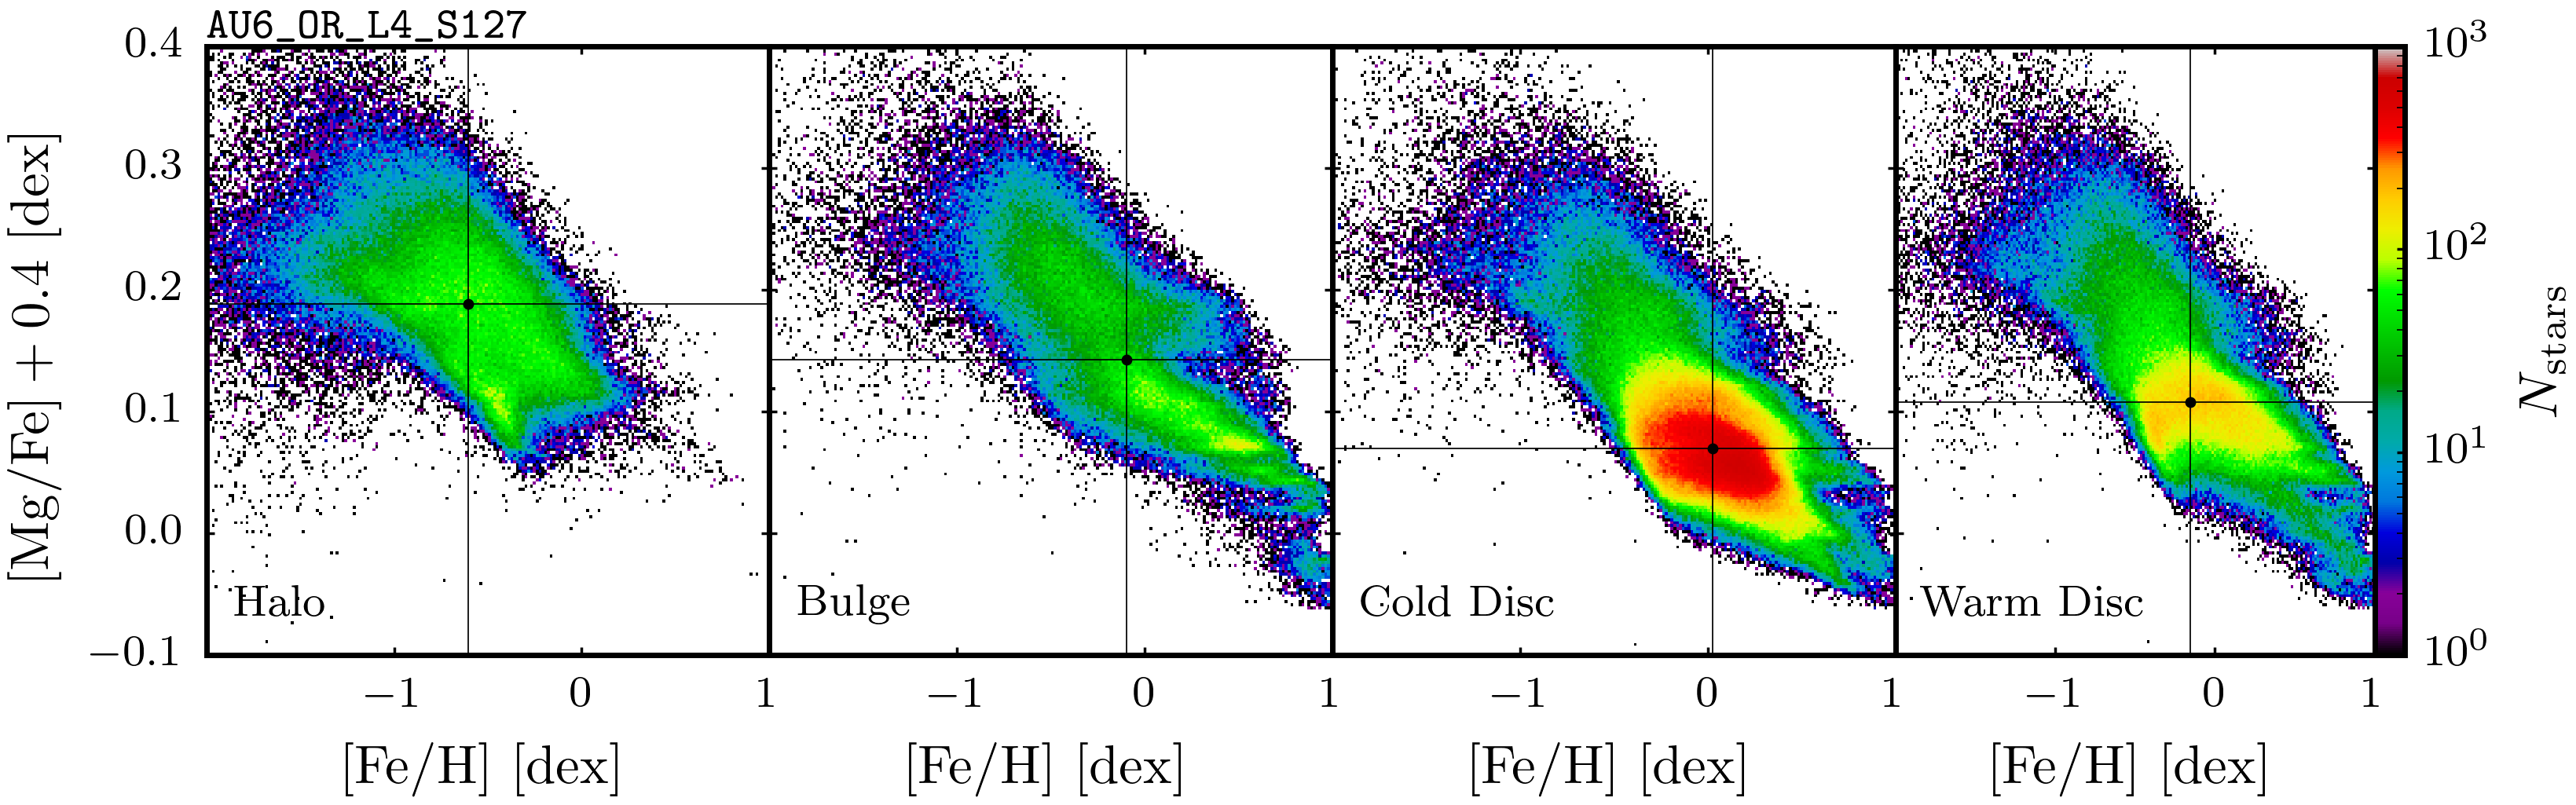

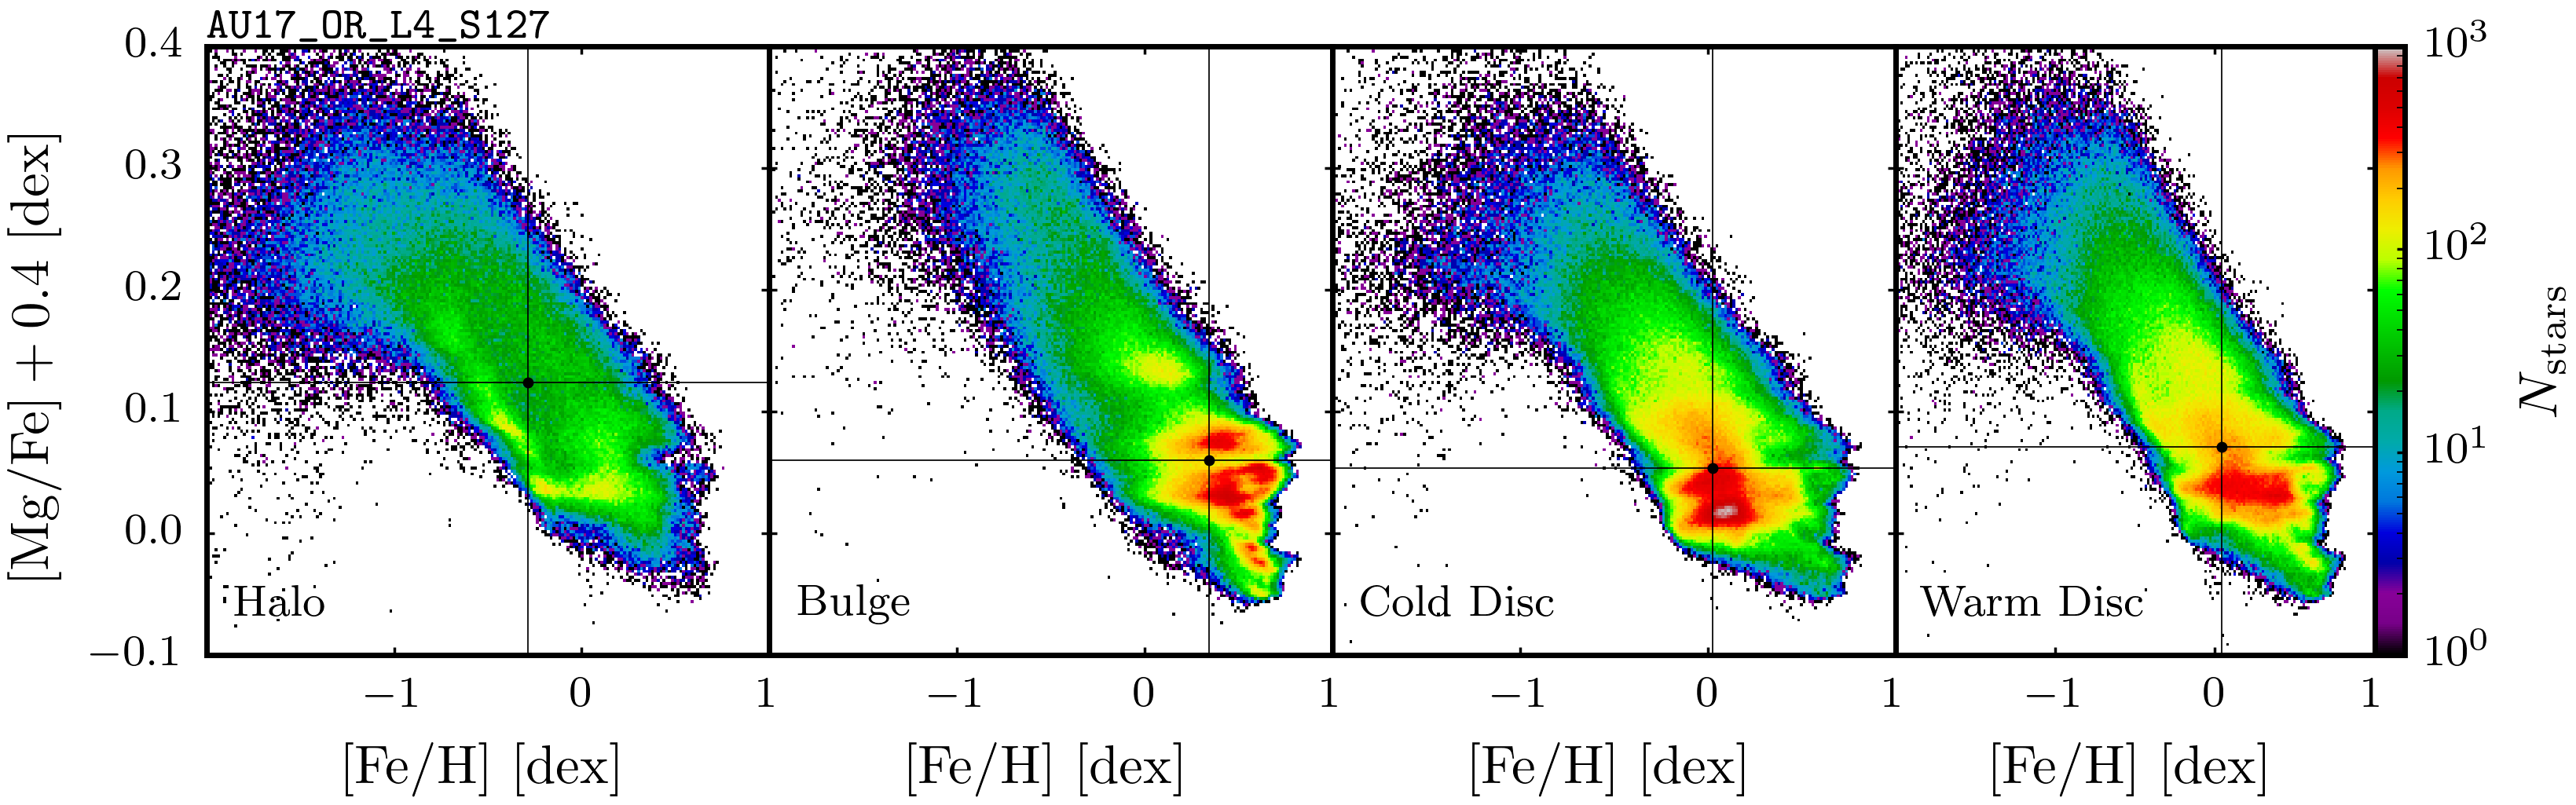

In [52]:
plot_abundance_rel_by_region_for_galaxy(simulation="au1_or_l4_s127")
plot_abundance_rel_by_region_for_galaxy(simulation="au6_or_l4_s127")
plot_abundance_rel_by_region_for_galaxy(simulation="au17_or_l4_s127")

## Tangential Velocity vs [Fe/H]

In [57]:
def plot_vphi_vs_abundance_for_galaxy(simulation: str):
    """
    This method creates a plot of the tangential velocity as a function of the
    Fe\H abundance for all subhalo stars.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(3.0, 3.0))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    ax.label_outer()
    ax.tick_params(which='both', direction="in")
    ax.set_xlim(-2, 1)
    ax.set_ylim(-200, 400)
    ax.set_xticks([-2, -1, 0, 1])
    # ax.set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
    ax.set_xlabel("[Fe/H] [dex]")
    ax.set_ylabel(r"$v_\varphi$ [$\mathrm{km} \, \mathrm{s}^{-1}$]")

    fe_to_h, _, _, v_phi = read_data(simulation=simulation)
    _, _, _, im = ax.hist2d(fe_to_h,
                            v_phi,
                            cmap="nipy_spectral",
                            bins=200,
                            range=[ax.get_xlim(), ax.get_ylim()],
                            norm=mcolors.LogNorm(vmin=1E0, vmax=1E3))
    # ax.plot(ax.get_xlim(),
    #         [np.nanmedian(mg_to_fe + 0.4),
    #          np.nanmedian(mg_to_fe + 0.4)],
    #         lw=.25, color='k')
    # ax.plot([np.nanmedian(fe_to_h),
    #          np.nanmedian(fe_to_h)],
    #         ax.get_ylim(),
    #         lw=.25, color='k')
    # ax.plot(np.nanmedian(fe_to_h),
    #         np.nanmedian(mg_to_fe + 0.4),
    #         marker='o', mfc='k', ms=2, mew=0)

    cbar = fig.colorbar(im, ax=ax, orientation='vertical',
                        label=r'$N_\mathrm{stars}$',
                        pad=0)
    cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

    ax.text(x=ax.get_xlim()[0],
            y=ax.get_ylim()[1],
            s=r"$\texttt{" + simulation.upper() + "}$",
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

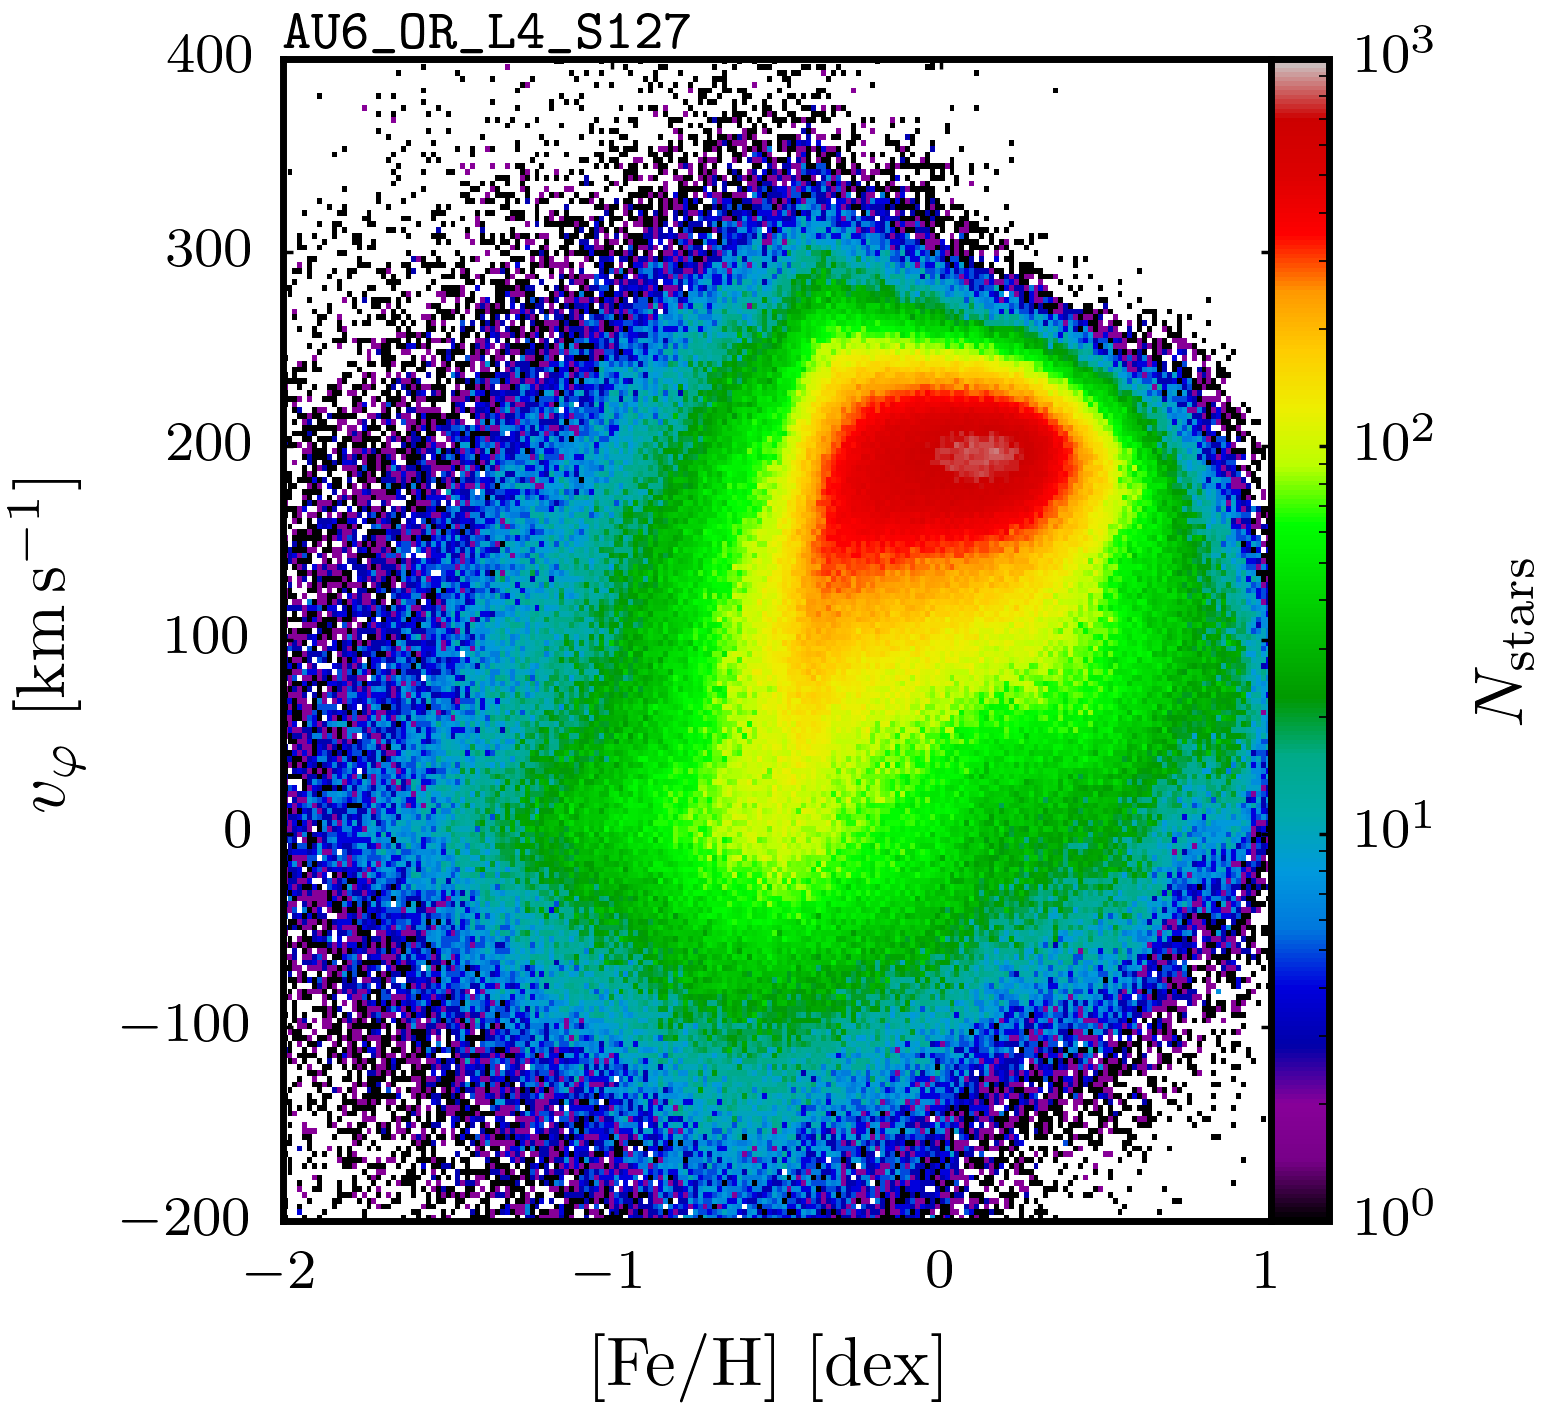

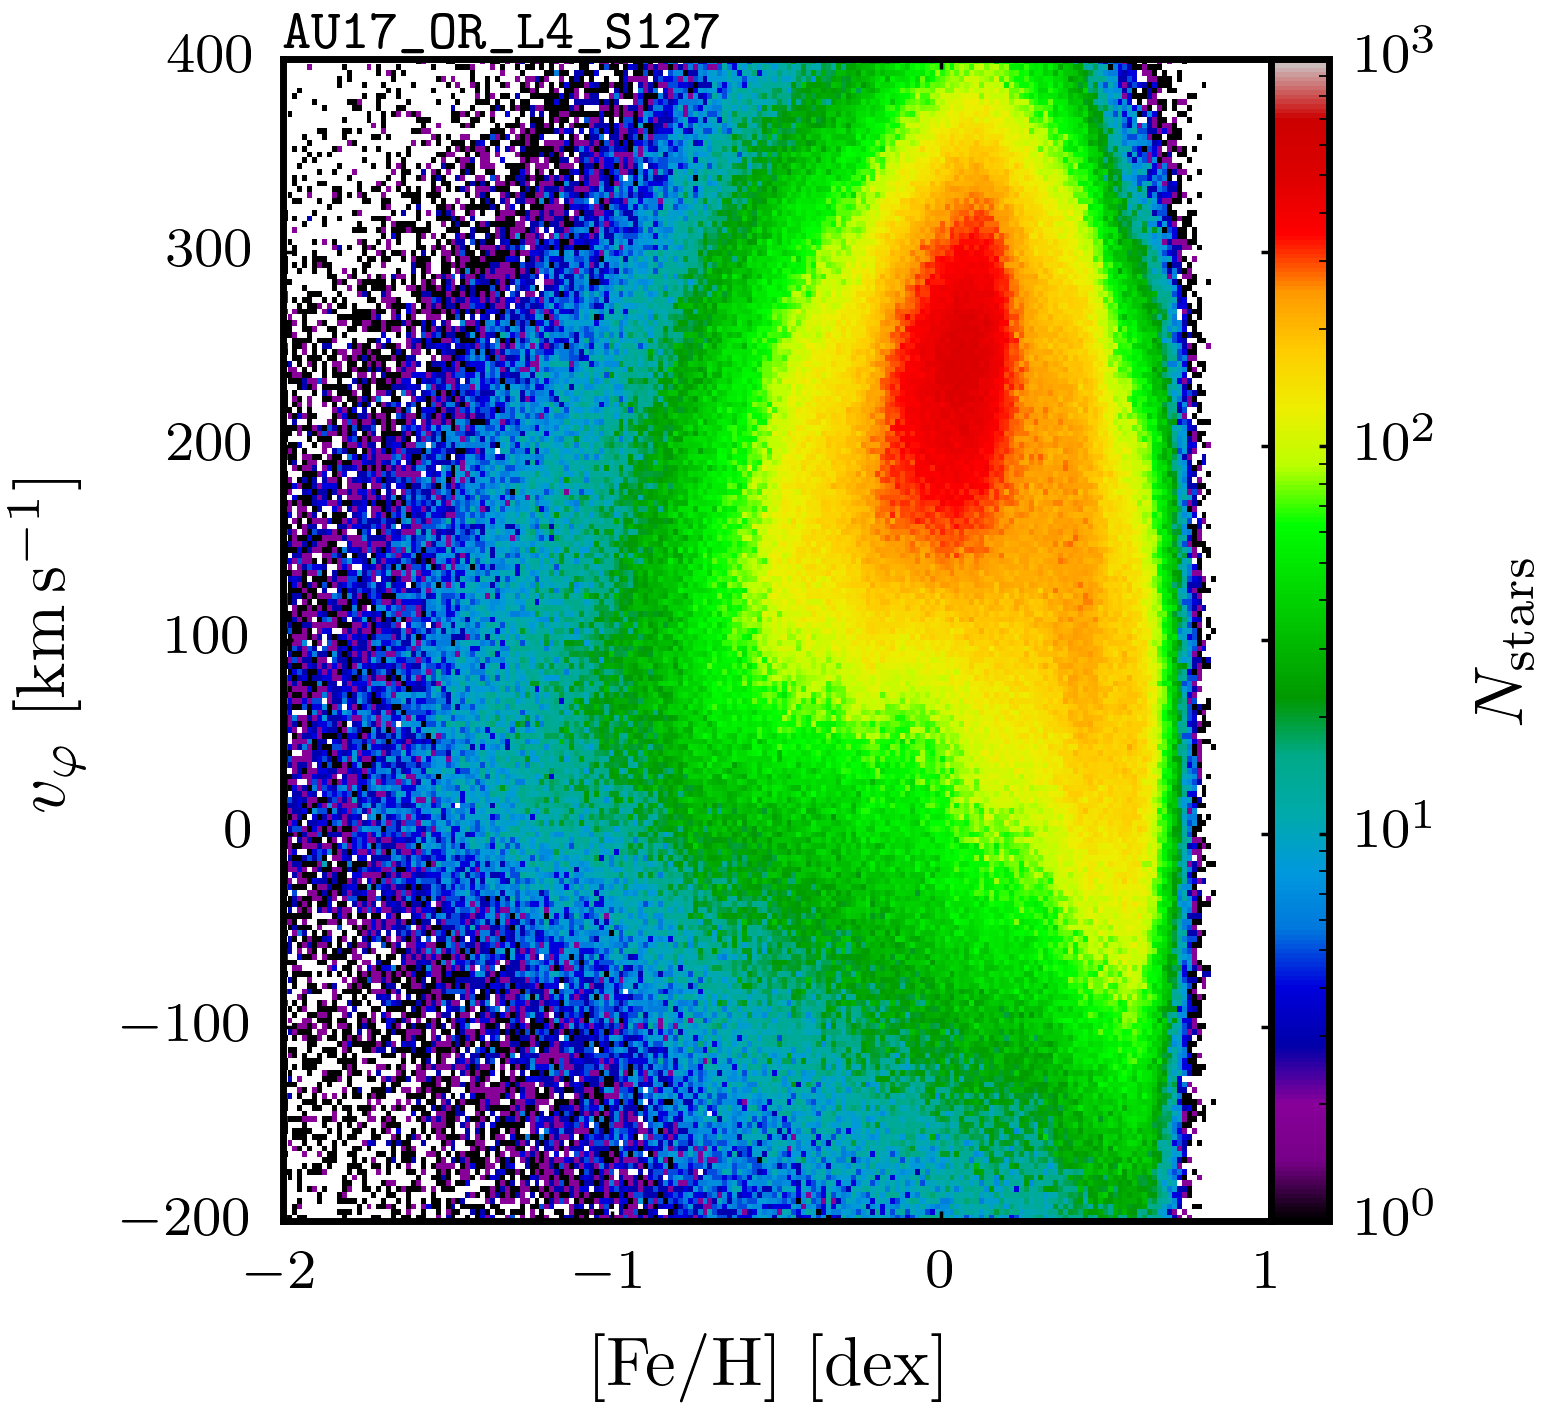

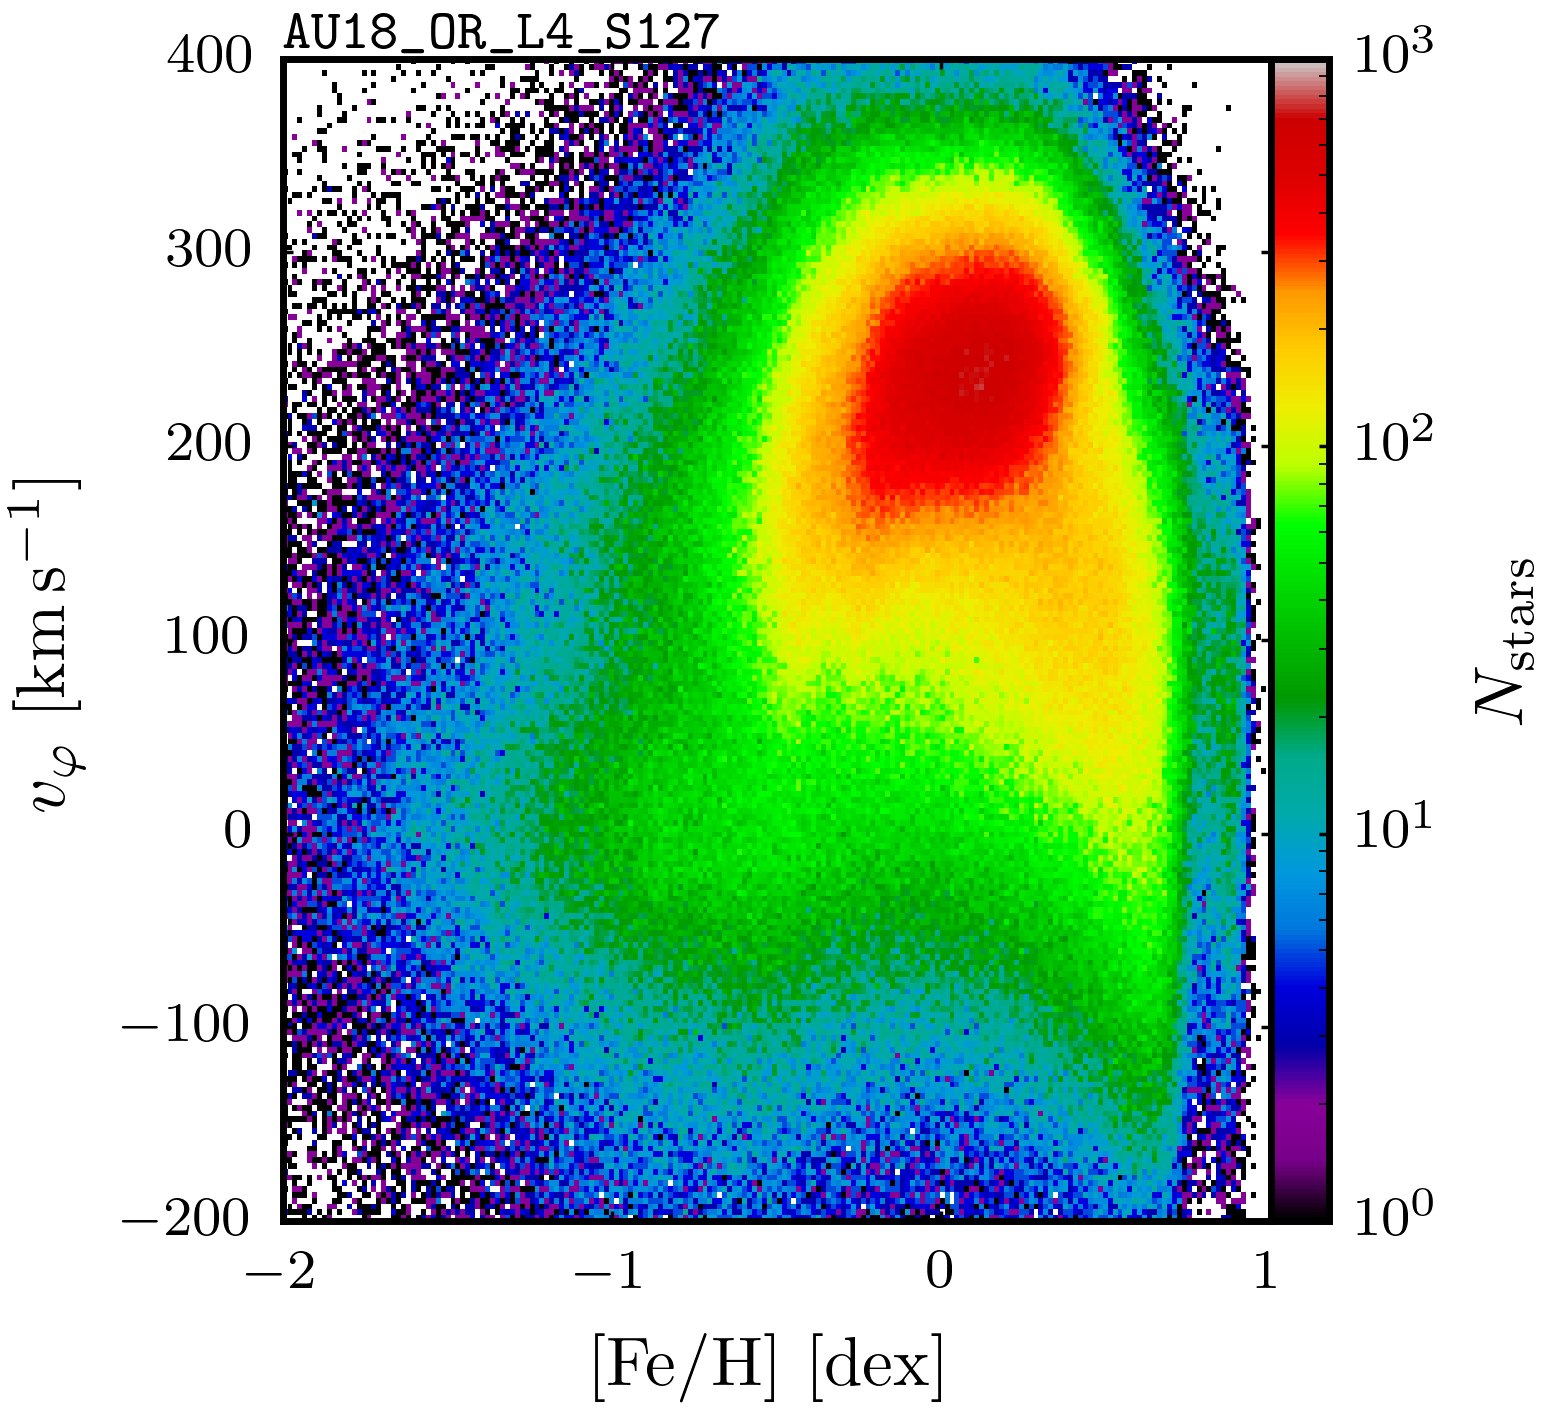

In [58]:
plot_vphi_vs_abundance_for_galaxy(simulation="au6_or_l4_s127")
plot_vphi_vs_abundance_for_galaxy(simulation="au17_or_l4_s127")
plot_vphi_vs_abundance_for_galaxy(simulation="au18_or_l4_s127")